In [247]:
import numpy as np
import itertools as iter
from matplotlib import pyplot as plt
from numpy import linalg as LA
from HW5_tools import ode_rkexplicit
from HW5_tools import limit_minmod, limit_vl, limit_none, limit_bj
g = 9.8

# HW5-Finite Volume Method for Shallow Water Equation

## Part0: Problem set
1. Implement a solver for the shallow water equations,
$$ \begin{bmatrix} h \\ h u \end{bmatrix}_t + \begin{bmatrix} hu \\ hu^2 + \frac g 2 h^2 \end{bmatrix}_x = 0 $$
where $h$ is water thickness, $hu$ is the momentum of a column of water, and $g$ is the gravitational potential.
The shallow water equations are very similar to isothermal gas dynamics except that the wave speed $c$ is not constant, but rather $\pm \sqrt{gh}$ as can be seen from the eigenvalues of the flux Jacobian.
* Choose initial conditions for your numerical experiments that create all possible configurations of subsonic and supersonic shocks and rarefactions.
* The total energy in the system is kinetic plus potential energy
$$ E = \int_{\Omega} \frac h 2 u^2 + \frac g 2 h^2 . $$
Compare the evolution of total energy using a first order method and a method using slope reconstruction, for a configuration with a shock and a configuration with only rarefactions.
* Does the result depend on your choice of Riemann solver, e.g., between HLL and Rusanov or between an exact solver and HLL?  Does it depend on your choice of limiter in slope reconstruction?

## Part1: Test on the exact solver

The Jacobian matrix of the flux vector is like: <br>

$$ J = \begin{bmatrix} 0 & 1\\ gh-u^2 & 2u \end{bmatrix} $$
<br>
So the eigenvalues are computed as $\lambda_1 = u + \sqrt{gh}$ and $\lambda_2 = u - \sqrt{gh}$, which are corresonding to two different wave speeds. The code of this part is an exact solver, where possible sub/supersonic shocks and rarefactions are all considered. <br>

The computation of the "star" region(between two waves) is very important, for it will decide the formulations of numerical fluxes. Using the Rankine-Hugoniot and the entropy condition$^{[1]}$, the mathematical expressions of the "velocity jump" can be derived as:

$$ u_* - u_L =  2(\sqrt{gh_l}-\sqrt{gh_*}) \ \ \ \ \ if \ h_*<h_l $$

$$ u_* - u_L =  -\sqrt{\frac{g(h_*+ h_l)(h_*-h_l)^2}{2h_*h_l}} \ \ \ \ \ if \ h_*>h_l $$

$$ u_r - u_* =  2(\sqrt{gh_r}-\sqrt{gh_*}) \ \ \ \ \ if \ h_*<h_r $$

$$ u_r - u_* =  -\sqrt{\frac{g(h_*+ h_r)(h_*-h_r)^2}{2h_*h_r}} \ \ \ \ \ if \ h_*>h_r $$

Where $h_*, h_l, h_r$ stand for the water thicknesses of each location in a Riemann problem, and note that the shocks occur when $h_*>h_l$ and $h_*>h_r$, while the rarefactions are generated when $h_*<h_l$ and $h_*<h_r$. In addition, if the velocity $u_0 + \sqrt{gh_0}$ or $u_0 - \sqrt{gh_0}$ equals to $0$ in the rarefaction regions, then the rarefactions are sonic.

[1]: Finite Volume methods for Hyperbolic Problems, Randall J. Leveque, Cambridge University Press, 2002.

In [248]:
'''the work of this homework is based on the code of the Jupyter Notebook:FVHyperbolic used in the class,
   and some changes have been made to solve this 1-D shallow water equation'''
def flux_water(U):  # taking input state vector        
    h = U[0]        # the water thickness 
    u = U[1] / h  # the velocity 
    return np.array([U[1], U[1]*u + h**2*g/2])


def riemann_water_exact(which, UL, UR, maxit=20):
    hL = UL[0]
    hR = UR[0]
    uL = UL[1] / hL
    uR = UR[1] / hR
    h = .5*(hL + hR)  # Initial guess to Newton solve
    ujumpL  = np.zeros(len(h))
    ujumpR  = np.zeros(len(h))
    dujumpL = np.zeros(len(h))
    dujumpR = np.zeros(len(h))

    # compute the velocity jumps#

    for i in range(maxit):

        for j in range(len(h)):
            if h[j]>hL[j]:
                ujumpL[j] = -np.sqrt(g*(h[j]+hL[j])*(h[j]-hL[j])**2/2/h[j]/hL[j])
            else:
                ujumpL[j] = 2*(np.sqrt(g*hL[j])-np.sqrt(g*h[j]))
        for j in range(len(h)):
            if h[j] > hR[j]:
                ujumpR[j] = -np.sqrt(g*(h[j]+hR[j])*(h[j]-hR[j])**2/2/h[j]/hR[j])
            else:
                ujumpR[j] = 2*(np.sqrt(g*hR[j])-np.sqrt(g*h[j]))

        residual = ujumpL + ujumpR - (uR - uL)

        if LA.norm(residual) < 1e-10:
            u = uL + ujumpL                           #u = u*
            break
        elif i+1 == maxit:
            raise RuntimeError('Newton solver failed to converge')


        for j in range(len(h)):
            if h[j]>hL[j]:
                dujumpL[j] = -0.5*(g*(h[j]+hL[j])*(h[j]-hL[j])**2/2/h[j]/hL[j])**(-0.5)\
                *((2*h[j]*hL[j]*(g*(h[j]-hL[j])**2+2*(h[j]-hL[j])*g*(h[j]+hL[j])))\
                  -2*g*(h[j]+hL[j])*(h[j]-hL[j])**2*hL[j])/4/h[j]**2/hL[j]**2
            else:
                dujumpL[j] = -g*(g*h[j])**(-0.5)

        for j in range(len(h)):
            if h[j]>hR[j]:
                dujumpR[j] = -0.5*(g*(h[j]+hR[j])*(h[j]-hR[j])**2/2/h[j]/hR[j])**(-0.5)\
                *((2*h[j]*hR[j]*(g*(h[j]-hR[j])**2+2*(h[j]-hR[j])*g*(h[j]+hR[j])))\
                  -2*g*(h[j]+hR[j])*(h[j]-hR[j])**2*hR[j])/4/h[j]**2/hR[j]**2
            else:
                dujumpR[j] = -g*(g*h[j])**(-0.5)

        delta_h = -residual / (dujumpL + dujumpR)
        
        while min(h + delta_h) <= 0:  # line search to prevent negative density
            delta_h *= .5
        h += delta_h


    U0 = np.zeros_like(UL)
    for i in range(len(h)):
        if uL[i] - np.sqrt(g*hL[i]) < 0 < u[i] - np.sqrt(g*h[i]) or u[i] + np.sqrt(g*h[i]) < 0 < uR[i] + np.sqrt(g*hR[i]):
            # Inside left (right) sonic rarefaction
            U0[0,i] = 1/g*(np.sign(u[i])*(u[i]-2*np.sqrt(g*h[i]))/3)**2
            U0[1,i] = U0[0,i] * np.sqrt(g*U0[1,i]) * np.sign(u[i])


        elif ((hL[i] >= h[i] and 0 <= uL[i] - np.sqrt(g*hL[i])) or
              (hL[i] <  h[i] and 0 < (h[i]*u[i] - UL[1,i]))):   #shock speed >0
        #     # Left rarefaction or shock is supersonic
            U0[:,i] = UL[:,i]
        elif ((hR[i] >= h[i] and uR[i] + np.sqrt(g*hR[i]) <= 0) or
              (hR[i] <  h[i] and UR[1][i] - h[i]*u[i]) > 0):    #shock speed <0
            # Right rarefaction or shock is supersonic
            U0[:,i] = UR[:,i]
        else:
            #Sample star state
            U0[0,i] = h[i]
            U0[1,i] = h[i]*u[i]

    return flux_water(U0)


def initial_water(x):
    return np.array([1 + 2*(np.exp(-(x*4)**2)>.5),
                        0*x])

def fvsolve2system(which, riemann, U0, a=-1, b=1, n=20, tfinal=1, limit=limit_minmod):
    dx = (b - a)/n
    x = np.linspace(a+dx/2, b-dx/2, n) # Element midpoints (centroids)
    U0x = U0(x)
    Ushape = U0x.shape
    idxL = np.arange(-1, n-1)          # periodic boundary conditions
    idxR = np.arange(1, n+1) % n

    def rhs(t, U):
        U = U.reshape(Ushape)
        jump = U[:,idxR] - U[:,idxL]
        r = np.zeros_like(jump)
        np.divide(U - U[:,idxL], jump, out=r, where=(jump!=0))
        g = limit(r) * jump / (2*dx)

        fluxL = riemann(which, U[:,idxL] + g[:,idxL] * dx/2, U - g * dx/2)
        return (fluxL - fluxL[:,idxR]).flatten() / dx
    hist = ode_rkexplicit(rhs, U0x.flatten(), h=dx/6, tfinal=tfinal)
    return x, [(t, U.reshape(Ushape)) for t, U in hist]



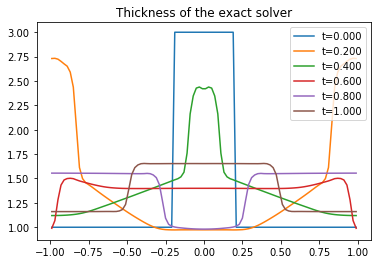

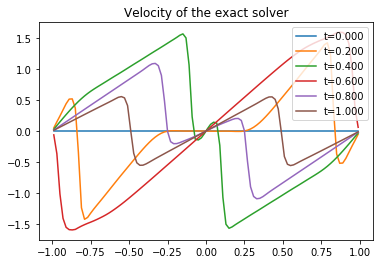

In [249]:
x, hist = fvsolve2system('exact', riemann_water_exact, initial_water, n=100, limit=limit_minmod)
plt.figure()
for t, U in hist[::len(hist)//5]:
    plt.plot(x, U[0], label='t={:.3f}'.format(t))
plt.title('Thickness of the exact solver')
plt.legend(loc='upper right')
plt.figure()
for t, U in hist[::len(hist)//5]:
    plt.plot(x, U[1]/U[0], label='t={:.3f}'.format(t))
plt.title('Velocity of the exact solver')
plt.legend(loc='upper right')
plt.show()

In this exact solver test, the same initial condition used in the class is applied. From the figures above, we can see relatively good dynamics of the water thickness and veclocity, for no oscillation or asymmetry occurs. 

## Part2: Test on the initial condition with all possible wave structures

In this part, a specifial initial condition will be set that all possible wave structures can be achieved. Specifically, the initial velocity $u$ is established as a step function while the initial water thickness is a constant. By this setting, the wave speeds $u-\sqrt{gh}$ and $u+\sqrt{gh}$ in different regions of the domain will lead to both supersonic/subsonic shocks and rarefactions. 

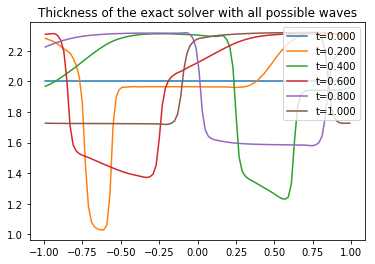

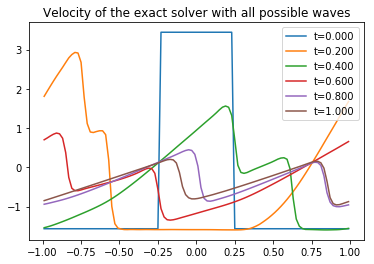

In [250]:
def initial_water_all(x):
    return np.array([0*x+2, np.where(x>=0.25, 0*x - np.sqrt(g), \
                                     np.where(x<=-0.25, 0*x - np.sqrt(g), 0*x + 2.2*np.sqrt(g)))])

x, hist = fvsolve2system('exact', riemann_water_exact, initial_water_all, n=100, limit=limit_minmod)
plt.figure()
for t, U in hist[::len(hist)//5]:
    plt.plot(x, U[0], label='t={:.3f}'.format(t))
plt.title('Thickness of the exact solver with all possible waves')
plt.legend(loc='upper right')
plt.figure()
for t, U in hist[::len(hist)//5]:
    plt.plot(x, U[1]/U[0], label='t={:.3f}'.format(t))
plt.title('Velocity of the exact solver with all possible waves')
plt.legend(loc='upper right')
plt.show()

## Part3: Test on the approximate solvers

The approximate solvers selected in this part are the HLL(Harten-Lax-Van Leer) solver and the Rusanov solver, which both assume that only two shocks will occur in the problem. Except for the supersonic cases, where the upwind flux will be used, the HLL method computes the sonic flux as:

$$F_{HLL}(U_*) = \frac{s_R f(U_L) - s_L f(U_R) + s_L s_R (U_R - U_L)}{s_R - s_L} . $$
And in Rusanov's scheme, it will be computed as:

$$F_{R}(U_*) = \frac 1 2 \Big( f(U_L) + f(U_R) \Big) - \frac s 2 \Big( U_R - U_L \Big) . $$

where the $s_L$, $s_R$ are left and right shock speeds, respectively.

In [251]:
def riemann_water_apx(which, UL, UR):
    hL = UL[0]
    hR = UR[0]
    uL = UL[1] / hL
    uR = UR[1] / hR
    sL = np.minimum(uL - np.sqrt(g*hL), uR - np.sqrt(g*hR))
    sR = np.maximum(uL + np.sqrt(g*hL), uR + np.sqrt(g*hR))
    fL = flux_water(UL)
    fR = flux_water(UR)
    if which == 'HLL':
        return np.where(sL > 0, fL,
                           np.where(sR < 0, fR,
                               (sR*fL - sL*fR + sL*sR*(UR - UL)) / (sR-sL)))
    if which == 'Rusanov':
        return np.where(sL > 0, fL,
                           np.where(sR < 0, fR,
                                  (fL+fR)/2 - 0.5*sR*(UR-UL)))



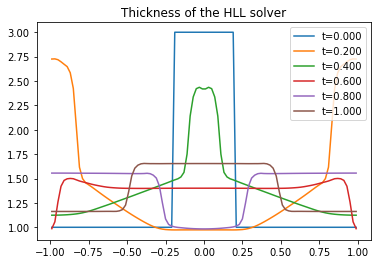

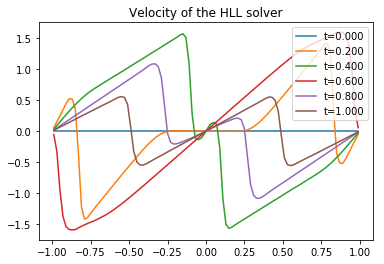

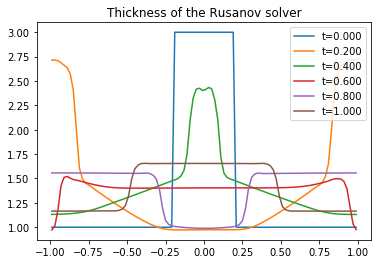

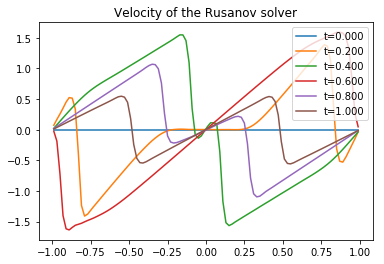

In [252]:
for appx_sol in ['HLL','Rusanov']:
    x, hist = fvsolve2system(appx_sol , riemann_water_apx, initial_water, n=100, limit=limit_minmod)
    plt.figure()
    for t, U in hist[::len(hist)//5]:
        plt.plot(x, U[0], label='t={:.3f}'.format(t))
    plt.title('Thickness of the ' +appx_sol + ' solver')
    plt.legend(loc='upper right');
    plt.figure()
    for t, U in hist[::len(hist)//5]:
        plt.plot(x, U[1]/U[0], label='t={:.3f}'.format(t))
    plt.title('Velocity of the ' +appx_sol + ' solver')
    plt.legend(loc='upper right');

In this part, the same initial condition applied in part1 is used in order to compare the approximate solvers with the exact one. From the figures above, we can see very similar results among them. However, when conducting the computation, the time step size has to be shrinked to avoid instability, which may show that these two methods are less stable than the exact solver. 

## Part4: Total energy evolution under specific configurations

The computation of the total energy defined as:

$$ E = \int_{\Omega} \frac h 2 u^2 + \frac g 2 h^2 . $$

of the whole domain is just the summation of all cell values. <br>

In this part, two specific initial configurations which one contains a shock and the other one has only rarefactions are applied. And in each case, three experiments are implemented with regard to the existence of limiters, the difference of approximate solvers and the difference between limiters. Unfortunately, we do not have a reference to nominate the "best" approximation, but from the figures below, we may make some conclusions.

In [253]:
def initial_one_shock(x):
    return np.array([np.where(x >= 0,1,0.5), 0*x])
def initial_rarefactions(x):
    return np.array([0*x+2, np.where(x>=0, 0*x + np.sqrt(g), 0*x - np.sqrt(g))])

### 4.1: With/Without slope reconstruction

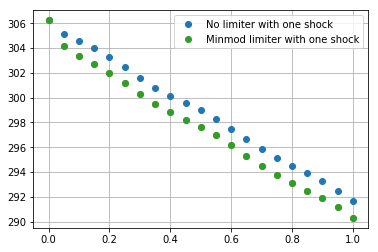

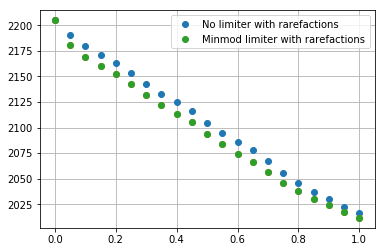

In [254]:
for ini in [initial_one_shock, initial_rarefactions]:
    for lim in[limit_none,limit_minmod]:
        x, hist = fvsolve2system('exact', riemann_water_exact, ini, n=100, limit= lim)
        time    = []
        value   = []
        for t, U in hist[::len(hist)//20]:
            E = 0
            for i in range(len(U[0])):
                E += 0.5*U[0][i]*(U[1][i]/U[0][i])**2 + g/2* (U[0][i])**2
            time.append(t)
            value.append(E)
        if ini == initial_one_shock and lim == limit_none:
            plt.figure()
            plt.plot(time,value,'o',label = 'No limiter with one shock')
            plt.legend(loc='upper right')
        if ini == initial_one_shock and lim == limit_minmod:
            plt.plot(time,value,'o')
            plt.plot(time,value,'o',label = 'Minmod limiter with one shock')
            plt.legend(loc='upper right')
            plt.grid()
            exact_shock_t = time
            exact_shock_v = value
        if ini == initial_rarefactions and lim == limit_none:
            plt.figure()
            plt.plot(time,value,'o',label = 'No limiter with rarefactions')
            plt.legend(loc='upper right')
        if ini == initial_rarefactions and lim == limit_minmod:
            plt.plot(time,value,'o')
            plt.plot(time,value,'o',label = 'Minmod limiter with rarefactions')
            plt.legend(loc='upper right')
            exact_rarf_t = time
            exact_rarf_v = value
plt.grid()
            

    

The benefits of implementing a limiter have been shown in the class, and in the figures above, distinct difference can be observed.

### 4.2: With HLL/Rusanov solver

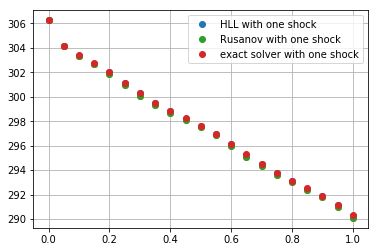

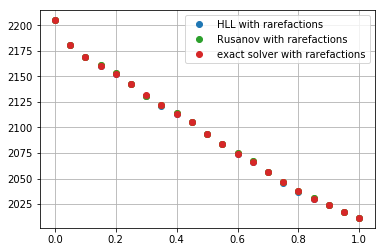

In [255]:
for ini in [initial_one_shock, initial_rarefactions]:
    for appx_sol in ['HLL','Rusanov']:
        x, hist = fvsolve2system(appx_sol, riemann_water_apx, ini, n=100, limit=limit_minmod)
        time    = []
        value   = []
        for t, U in hist[::len(hist)//20]:
            E = 0
            for i in range(len(U[0])):
                E += 0.5*U[0][i]*(U[1][i]/U[0][i])**2 + g/2* (U[0][i])**2
            time.append(t)
            value.append(E)
        if ini == initial_one_shock and appx_sol == 'HLL':
            plt.figure()
            plt.plot(time,value,'o',label = 'HLL with one shock')
            plt.legend(loc='upper right')
        if ini == initial_one_shock and appx_sol == 'Rusanov':
            plt.plot(time,value,'o')
            plt.plot(time,value,'o',label = 'Rusanov with one shock')
            plt.plot(exact_shock_t,exact_shock_v, 'o',label = 'exact solver with one shock')
            plt.legend(loc='upper right')
            plt.grid()
        if ini == initial_rarefactions and appx_sol == 'HLL':
            plt.figure()
            plt.plot(time,value,'o',label = 'HLL with rarefactions')
            plt.legend(loc='upper right')
        if ini == initial_rarefactions and appx_sol == 'Rusanov':
            plt.plot(time,value,'o')
            plt.plot(time,value,'o',label = 'Rusanov with rarefactions')
            plt.plot(exact_rarf_t,exact_rarf_v, 'o',label = 'exact solver with rarefactions')
            plt.legend(loc='upper right')
plt.grid()
            



The energy evolution diagrams of the three solvers are presented above, and we cannot see huge difference among them. Therefore, we may conclude that for these two special initial configurations, the HLL solver, Rusanov solver and the exact solver are convertible. However, as noted above, the exact sovler is more stable than the two approximate solvers. 

### 4.3: With different limiters

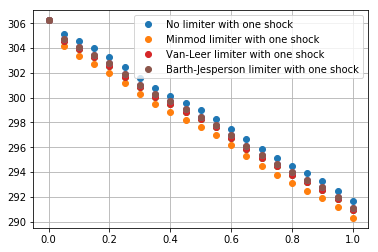

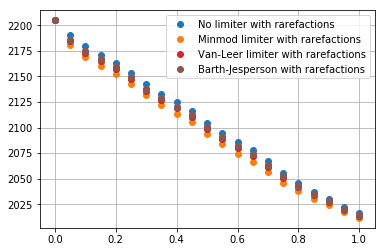

In [256]:
for ini in [initial_one_shock, initial_rarefactions]:
    for lim in[limit_none, limit_minmod,limit_vl,limit_bj]:
        time    = []
        value   = []
        x, hist = fvsolve2system('exact', riemann_water_exact, ini, n=100, limit= lim)
        for t, U in hist[::len(hist)//20]:
            E = 0
            for i in range(len(U[0])):
                E += 0.5*U[0][i]*(U[1][i]/U[0][i])**2 + g/2* (U[0][i])**2
            time.append(t)
            value.append(E)
        if ini == initial_one_shock and lim == limit_none:
            plt.figure()
            plt.plot(time,value,'o',label = 'No limiter with one shock')
            plt.legend(loc='upper right')
        if ini == initial_one_shock and lim == limit_minmod:
            plt.plot(time,value,'o',label = 'Minmod limiter with one shock')
            plt.legend(loc='upper right')
        if ini == initial_one_shock and lim == limit_vl:
            plt.plot(time,value,'o')
            plt.plot(time,value,'o',label = 'Van-Leer limiter with one shock')
            plt.legend(loc='upper right')
        if ini == initial_one_shock and lim == limit_bj:
            plt.plot(time,value,'o')
            plt.plot(time,value,'o',label = 'Barth-Jesperson limiter with one shock')
            plt.legend(loc='upper right')
            plt.grid()
        if ini == initial_rarefactions and lim == limit_none:
            plt.figure()
            plt.plot(time,value,'o',label = 'No limiter with rarefactions')
            plt.legend(loc='upper right')
        if ini == initial_rarefactions and lim == limit_minmod:
            plt.plot(time,value,'o',label = 'Minmod limiter with rarefactions')
            plt.legend(loc='upper right')
        if ini == initial_rarefactions and lim == limit_vl:
            plt.plot(time,value,'o')
            plt.plot(time,value,'o',label = 'Van-Leer limiter with rarefactions')
            plt.legend(loc='upper right')
        if ini == initial_rarefactions and lim == limit_bj:
            plt.plot(time,value,'o')
            plt.plot(time,value,'o',label = 'Barth-Jesperson with rarefactions')
            plt.legend(loc='upper right')
plt.grid()
            

    

The computation results with the implementation of three particular limiters along with the case of no limiter are shown as the figures above. Clearly, the difference between each choice can be identified and as the time evolves, that difference turns out to be the same in the shock case and relatively decreases in the rarefaction case.